In [1]:
import os
import PIL
import numpy as np
import tensorflow as tf
import seaborn as sns
import matplotlib.pyplot as plt

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

In [2]:
sns.set_style("darkgrid")

`2. Load Datasets`

    Here, we will use Tensorflow's "image_dataset_from_directory" to load the image direct from the directory into
    Keras. In addition to loading the dataset, the methods also splits the data into train and validation sets.

In [3]:
batch_size = 30 # Number of images in a grouping for processing
img_height = 180 # All images height (180 pixels)
img_width = 180 # All images width (180 pixels)

In [4]:
data_one_dir = "./Data/Balanced_Dataset/" # Directory path
data_two_dir = "./Data/Marginalize_W_25/"
data_three_dir = "./Data/Marginalize_B_25/"

In [5]:
import pathlib

data_one_dir = pathlib.Path(data_one_dir)
data_two_dir = pathlib.Path(data_two_dir)
data_three_dir = pathlib.Path(data_three_dir)

In [6]:
def load_datasets(data_dir):
    
    # load dataset and get 80% of it for training
    train_ds = tf.keras.preprocessing.image_dataset_from_directory(
        data_dir,
        validation_split=0.2,
        subset="training",
        seed=1337,
        image_size=(img_width, img_height),
        batch_size=batch_size,
    )
    
    # load dataset and get 20% of it for validation
    val_ds = tf.keras.preprocessing.image_dataset_from_directory(
        data_dir,
        validation_split=0.2,
        subset="validation",
        seed=1337,
        image_size=(img_width, img_height),
        batch_size=batch_size,
    )
    
    return (train_ds, val_ds)

In [7]:
# Load all three datasets
# train_ds_one, val_ds_one = load_datasets(data_dir=data_one_dir)
train_ds_two, val_ds_two = load_datasets(data_dir=data_two_dir)
train_ds_three, val_ds_three = load_datasets(data_dir=data_three_dir)

Found 4800 files belonging to 2 classes.
Using 3840 files for training.
Found 4800 files belonging to 2 classes.
Using 960 files for validation.
Found 4800 files belonging to 2 classes.
Using 3840 files for training.
Found 4800 files belonging to 2 classes.
Using 960 files for validation.


`3. Visualize Image Data`

In [8]:
# Balanced Datasets

# Setting figure size
plt.figure(figsize=(20, 20))

# Loop through train set taking the 1st batch
for images, labels in train_ds_two.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(int(labels[i]))
        plt.axis("off")

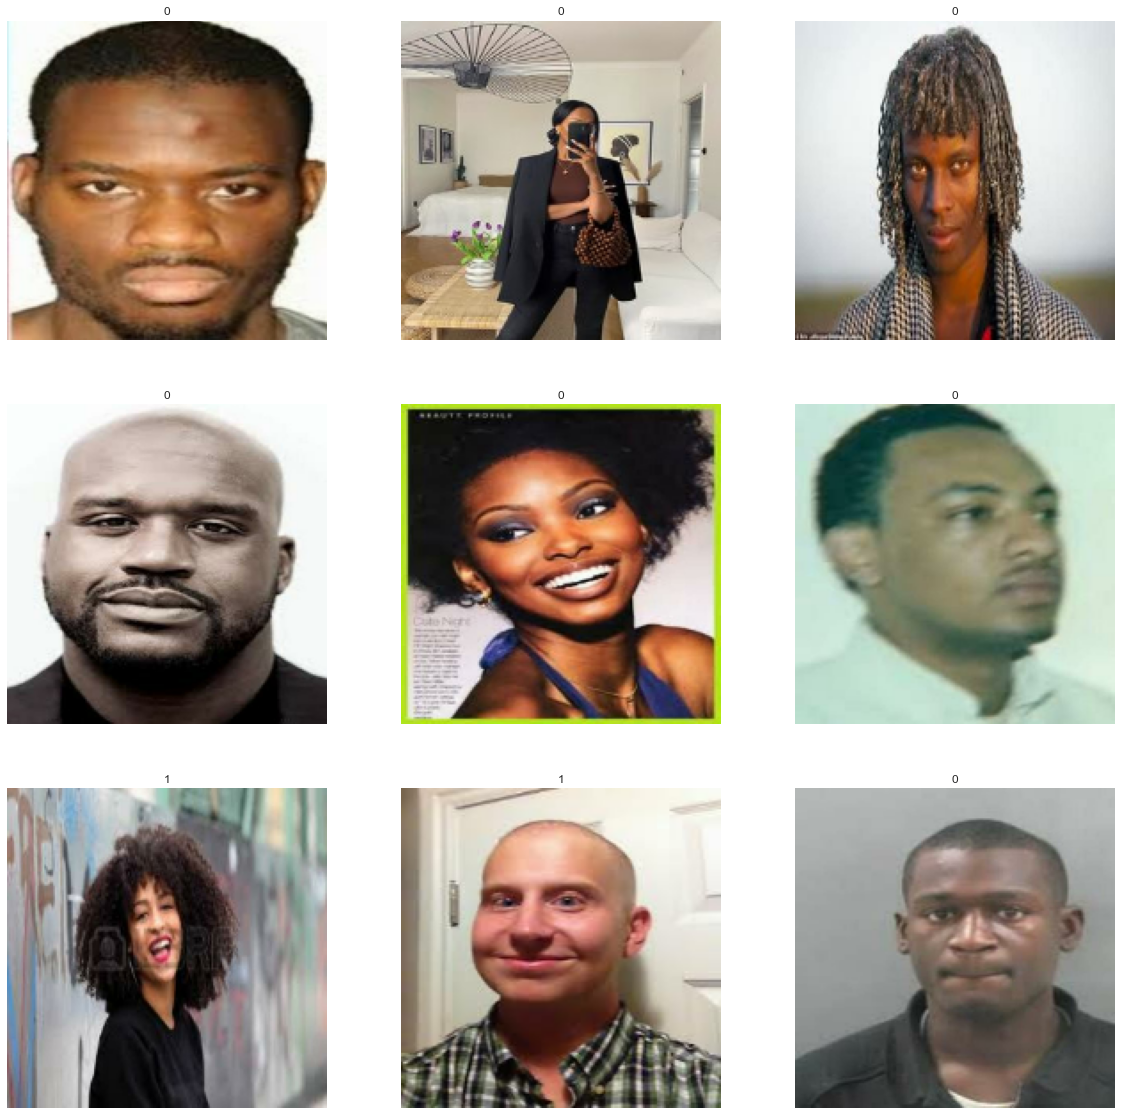

In [9]:
# Marginalised White

# Setting figure size
plt.figure(figsize=(20, 20))

# Loop through train set taking the 1st batch
for images, labels in train_ds_two.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(int(labels[i]))
        plt.axis("off")

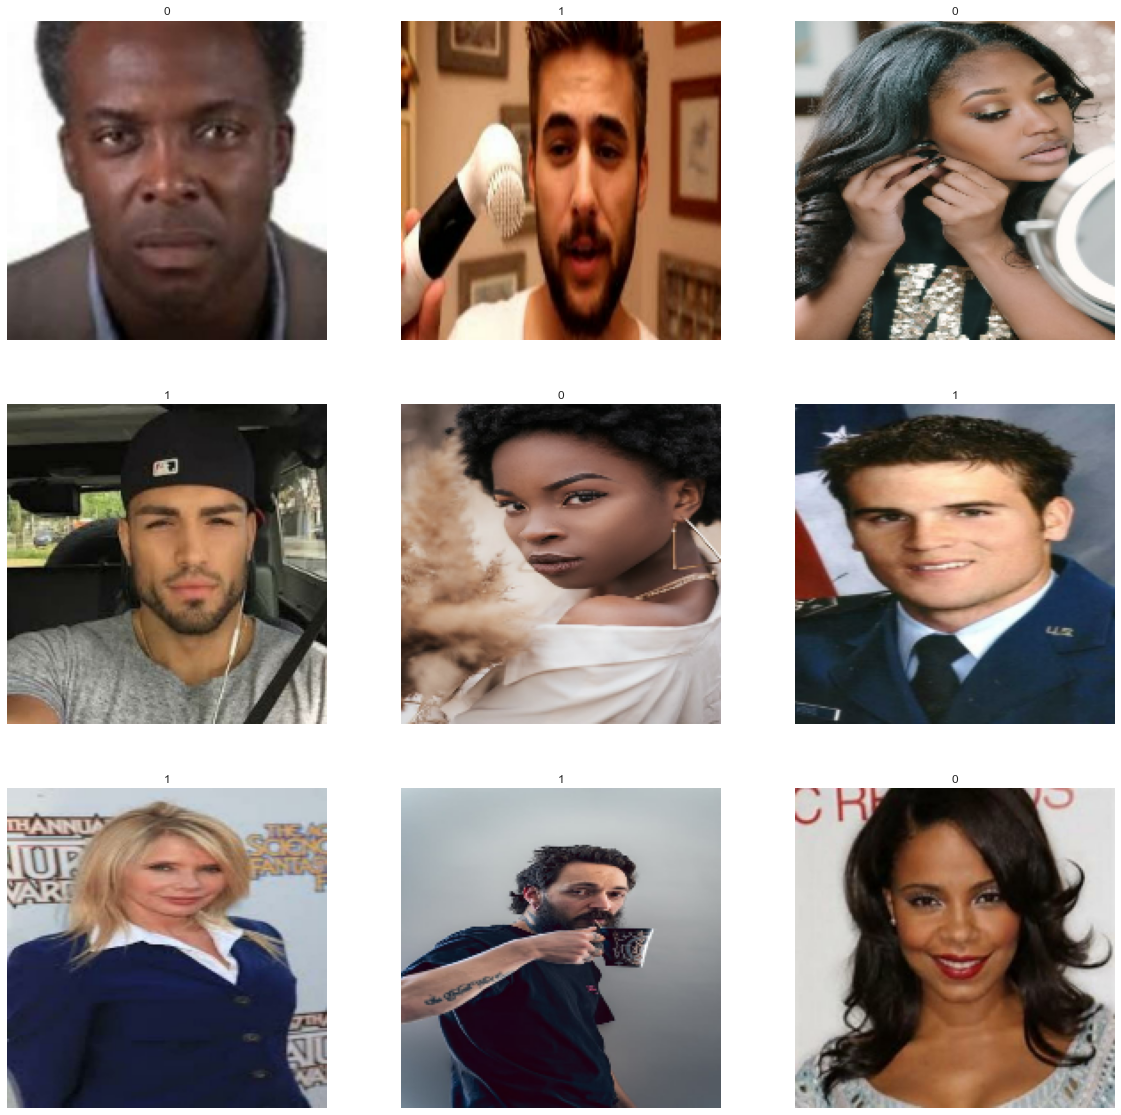

In [9]:
# Marginalized Black

# Setting figure size
plt.figure(figsize=(20, 20))

# Loop through train set taking the 1st batch
for images, labels in train_ds_three.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(int(labels[i]))
        plt.axis("off")

`4. Image Preprocessing`

    1. Standardization:
    
    Neural networks works well with smaller input values. In our work, it's important to note that each image 
    pixel is represented by an RBG value between [0, 255].
    
    Hence, we will add a layer that standardizes the values between [0, 1].
    
    "layers.experimental.preprocessing.Rescaling(1./255, input_shape=(img_height, img_width, 3))"
    
    
    2. Add catch() and prefetching()
    
    In the preprocessing step of every image, the images are loaded on the disk at each layer of NN, and loaded
    off the disk. To enhance the performance of our systems, we will want to catch those images and use prefetch
    to yield them in the next layer so we keep a memory of them.

In [10]:
def autotune(train_ds, val_ds):
    # Configuring dataset for performance
    AUTOTUNE = tf.data.experimental.AUTOTUNE

    # catching imgs in memory & yielding
    # them into the next layer
    train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE) 
    val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)
    
    return (train_ds, val_ds)

# Apply for all three datasets
# autotune(train_ds=train_ds_one, val_ds=val_ds_one)
autotune(train_ds=train_ds_two, val_ds=val_ds_two)
autotune(train_ds=train_ds_three, val_ds=val_ds_three)

(<PrefetchDataset shapes: ((None, 180, 180, 3), (None,)), types: (tf.float32, tf.int32)>,
 <PrefetchDataset shapes: ((None, 180, 180, 3), (None,)), types: (tf.float32, tf.int32)>)

`5. Building Image Classifier`

    In building a classifier, Keras requires that we first instantiate the model, compile it, fit the data,
    and then make the model to make a prediction. The mentioned steps are what will be followed here.
    
    Note:
        * In our preprocessing step, we mentioned that we will define a layer for standardization. That layer 
          is defined as the first layer in the Model.
        * The model that we will be working with a Sequential. We can choose other models.

`Data Augmentation`

In [11]:
data_augmentation = keras.Sequential([
    layers.experimental.preprocessing.RandomFlip("horizontal", input_shape=(img_height, img_width,3)),
    layers.experimental.preprocessing.RandomRotation(0.1),
    layers.experimental.preprocessing.RandomZoom(0.1),
  ])

In [12]:
def model(train_ds, val_ds):
    
    # Model Instantiate
    model = tf.keras.Sequential([
      data_augmentation,
      layers.experimental.preprocessing.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
      layers.Conv2D(32, 3, activation='relu'),
      layers.MaxPooling2D(),
      layers.Conv2D(32, 3, activation='relu'),
      layers.MaxPooling2D(),
      layers.Conv2D(32, 3, activation='relu'),
      layers.MaxPooling2D(),
      layers.Dropout(0.2),
      layers.Flatten(),
      layers.Dense(128, activation='relu'),
      layers.Dense(2)
    ])
    
    # Model Compile
    model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy']
             )
    
    # Fit
    results = model.fit(
      train_ds,
      validation_data=val_ds,
      epochs=10
    )
    
    return results

In [13]:
# Visualize Accuracy and Validation
def visualize_accuracy(results):
    
    acc = results.history['accuracy']
    val_acc = results.history['val_accuracy']

    def plot_accuracy(training_acc, validation_acc):

        epochs_range = range(10)

        fig = plt.figure(figsize=(10, 5))

        plt.plot(epochs_range, training_acc, label='Training Accuracy')
        plt.plot(epochs_range, validation_acc, label='Validation Accuracy')

        plt.title('Training Accuracy')
        plt.legend(loc='lower right')
        plt.ylim((0, 1))

    plot_accuracy(training_acc=acc, validation_acc=val_acc)

`Fit model on data`

In [18]:
# Fit balanced dataset
results_one = model(train_ds=train_ds_one, val_ds=val_ds_one)

Epoch 1/10
134/134 [==============================] - 166s 1s/step - loss: 0.6679 - accuracy: 0.6162 - val_loss: 0.6077 - val_accuracy: 0.6760
Epoch 2/10
134/134 [==============================] - 192s 1s/step - loss: 0.5744 - accuracy: 0.7050 - val_loss: 0.5403 - val_accuracy: 0.7090
Epoch 3/10
134/134 [==============================] - 166s 1s/step - loss: 0.5453 - accuracy: 0.7190 - val_loss: 0.5217 - val_accuracy: 0.7350
Epoch 4/10
134/134 [==============================] - 165s 1s/step - loss: 0.5098 - accuracy: 0.7477 - val_loss: 0.5138 - val_accuracy: 0.7400
Epoch 5/10
134/134 [==============================] - 163s 1s/step - loss: 0.4900 - accuracy: 0.7628 - val_loss: 0.4950 - val_accuracy: 0.7640
Epoch 6/10
134/134 [==============================] - 162s 1s/step - loss: 0.4854 - accuracy: 0.7623 - val_loss: 0.4703 - val_accuracy: 0.7620
Epoch 7/10
134/134 [==============================] - 161s 1s/step - loss: 0.4756 - accuracy: 0.7675 - val_loss: 0.4608 - val_accuracy: 0.7960

In [21]:
visualize_accuracy(results=results_one)

In [14]:
# Marginalised dataset
results_two = model(train_ds=train_ds_two, val_ds=val_ds_two)

Epoch 1/10
128/128 [==============================] - 279s 2s/step - loss: 0.5227 - accuracy: 0.7604 - val_loss: 0.4348 - val_accuracy: 0.7906
Epoch 2/10
128/128 [==============================] - 184s 1s/step - loss: 0.4533 - accuracy: 0.7951 - val_loss: 0.3736 - val_accuracy: 0.8396
Epoch 3/10
128/128 [==============================] - 174s 1s/step - loss: 0.4288 - accuracy: 0.8128 - val_loss: 0.3512 - val_accuracy: 0.8396
Epoch 4/10
128/128 [==============================] - 185s 1s/step - loss: 0.4142 - accuracy: 0.8143 - val_loss: 0.3401 - val_accuracy: 0.8396
Epoch 5/10
128/128 [==============================] - 179s 1s/step - loss: 0.3964 - accuracy: 0.8219 - val_loss: 0.3323 - val_accuracy: 0.8448
Epoch 6/10
128/128 [==============================] - 174s 1s/step - loss: 0.3781 - accuracy: 0.8352 - val_loss: 0.3027 - val_accuracy: 0.8646
Epoch 7/10
128/128 [==============================] - 169s 1s/step - loss: 0.3594 - accuracy: 0.8456 - val_loss: 0.3101 - val_accuracy: 0.8719

In [15]:
visualize_accuracy(results=results_two)

In [16]:
# Fit balanced dataset
results_three = model(train_ds=train_ds_three, val_ds=val_ds_three)

Epoch 1/10
128/128 [==============================] - 837s 7s/step - loss: 0.5201 - accuracy: 0.7529 - val_loss: 0.5881 - val_accuracy: 0.6885
Epoch 2/10
128/128 [==============================] - 239s 2s/step - loss: 0.4605 - accuracy: 0.7807 - val_loss: 0.4613 - val_accuracy: 0.7885
Epoch 3/10
128/128 [==============================] - 205s 2s/step - loss: 0.4270 - accuracy: 0.8044 - val_loss: 0.4485 - val_accuracy: 0.8000
Epoch 4/10
128/128 [==============================] - 206s 2s/step - loss: 0.4117 - accuracy: 0.8109 - val_loss: 0.4053 - val_accuracy: 0.8271
Epoch 5/10
128/128 [==============================] - 216s 2s/step - loss: 0.3950 - accuracy: 0.8232 - val_loss: 0.4159 - val_accuracy: 0.8083
Epoch 6/10
128/128 [==============================] - 192s 1s/step - loss: 0.4022 - accuracy: 0.8128 - val_loss: 0.4101 - val_accuracy: 0.8188
Epoch 7/10
128/128 [==============================] - 203s 2s/step - loss: 0.3713 - accuracy: 0.8326 - val_loss: 0.4057 - val_accuracy: 0.8052

In [25]:
visualize_accuracy(results=results_three)

`Let us make a prediction! :) :) :)`

    Due to noise in our datasets, we will only use portraits for predictions on this model.

In [26]:
class_names = ['Black', 'White']

`Experiment 1`

In [32]:
def plot_accuracy(img_list, dir_path, title, model):
    """
    :img_list: List of images for testing
    :dir_path: Directory to the folder containing images
        e.g. "./Images/"
    """
    
    accuracy_scores = list()
    x_values = list()
    
    index = 0
    while index < len(img_list):
    
        img = keras.preprocessing.image.load_img(
        dir_path + img_list[index], target_size=(img_height, img_width)
        )

        img_array = keras.preprocessing.image.img_to_array(img)
        img_array = tf.expand_dims(img_array, 0) # Create a batch

        predictions = model.predict(img_array)
        score = tf.nn.softmax(predictions[0])
        score = class_names[np.argmax(score)], 100 * np.max(score)
        accuracy_scores.append(score[1])
        x_values.append(index + 1)
        
        index += 1
        
        
    fig = plt.figure(figsize=(10, 5))
    
    ax = sns.lineplot(x=x_values, y=accuracy_scores, markers=["o"])
    
    # Visual Features
    plt.ylim((0, 100))
    plt.grid(axis='y')
    
    
    # Visual Attribues
    plt.title("Accuracy Scores - {}".format(title), fontdict={'fontsize': 13, 'fontweight': 'bold'})
    plt.xlabel("Image Number")
    plt.ylabel("Accuracy (%)")
    
    
    # Basic Stats on Accuracy
    basic_stats = {
        'Mean': np.mean(accuracy_scores),
        'Min': np.min(accuracy_scores),
        'Max': np.max(accuracy_scores),
    }
    
    return basic_stats

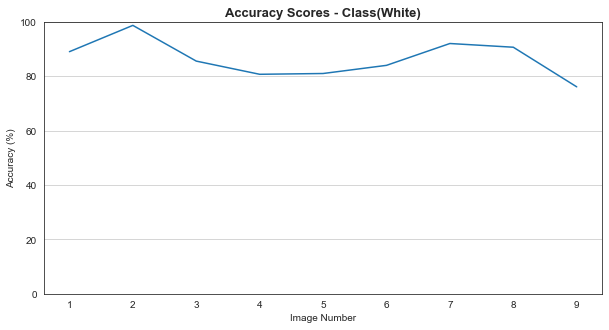

In [36]:
# Balanced Dataset

# Test Predictions on white people
sns.set_style("white")

img_lst = ['Test1.jpeg', 'Test2.jpeg', 'Test3.jpeg', 'Test4.jpeg', 'Test5.jpeg', 
           'Test6.jpeg', 'Test7.jpeg', 'Test8.jpeg', 'Test9.jpeg']
dir_path = "./Dataset/Test_Images/White/"

stats = plot_accuracy(img_list=img_lst, dir_path=dir_path, title="Class(White)", model=results_one.model)
plt.savefig("Balanced_accuracy_white")

In [35]:
import pandas as pd
pd.DataFrame(stats, index=[0])

Mean        Min        Max
0  86.47385  76.144296  98.756754

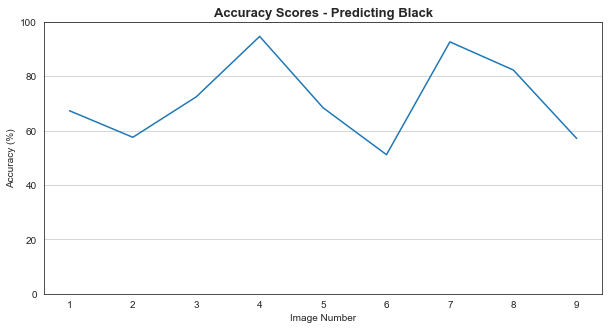

In [37]:
# Balanced Dataset
# Test Predictions on black people

img_lst = ['Test1.png', 'Test2.jpeg', 'Test4.jpeg', 'Test18.jpeg', 'Test14.jpeg', 
           'Test19.jpeg', 'Test16.jpeg', 'Test8.jpeg', 'Test10.jpeg']
dir_path = "./Dataset/Test_Images/Black/"

stats = plot_accuracy(img_list=img_lst, dir_path=dir_path, title="Predicting Black", model=results_one.model)
plt.savefig("Balanced_accuracy_black")

In [38]:
import pandas as pd
pd.DataFrame(stats, index=[0])

Mean        Min        Max
0  71.546817  51.176703  94.702464

In [39]:
# Marginalized White

# Test Predictions on white people
sns.set_style("white")

img_lst = ['Test1.jpeg', 'Test2.jpeg', 'Test3.jpeg', 'Test4.jpeg', 'Test5.jpeg', 
           'Test6.jpeg', 'Test7.jpeg', 'Test8.jpeg', 'Test9.jpeg']
dir_path = "./Dataset/Test_Images/White/"

stats = plot_accuracy(img_list=img_lst, dir_path=dir_path, title="Class(White)", model=results_two.model)
plt.savefig("Balanced_accuracy_white")

In [40]:
import pandas as pd
pd.DataFrame(stats, index=[0])

Mean        Min        Max
0  77.441051  50.933361  93.919408

In [41]:
# Marginalized White

# Test Predictions on black people

img_lst = ['Test1.png', 'Test2.jpeg', 'Test4.jpeg', 'Test18.jpeg', 'Test14.jpeg', 
           'Test19.jpeg', 'Test16.jpeg', 'Test8.jpeg', 'Test10.jpeg']
dir_path = "./Dataset/Test_Images/Black/"

stats = plot_accuracy(img_list=img_lst, dir_path=dir_path, title="Predicting Black", model=results_two.model)
plt.savefig("Balanced_accuracy_black")

In [42]:
import pandas as pd
pd.DataFrame(stats, index=[0])

Mean        Min        Max
0  98.669259  94.038123  99.987102

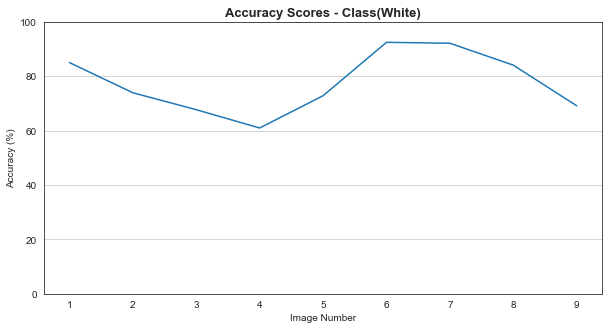

In [43]:
# Marginalized Black

# Test Predictions on white people
sns.set_style("white")

img_lst = ['Test1.jpeg', 'Test2.jpeg', 'Test3.jpeg', 'Test4.jpeg', 'Test5.jpeg', 
           'Test6.jpeg', 'Test7.jpeg', 'Test8.jpeg', 'Test9.jpeg']
dir_path = "./Dataset/Test_Images/White/"

stats = plot_accuracy(img_list=img_lst, dir_path=dir_path, title="Class(White)", model=results_three.model)
plt.savefig("Balanced_accuracy_white")

In [44]:
import pandas as pd
pd.DataFrame(stats, index=[0])

Mean        Min        Max
0  77.629726  61.005366  92.522359

In [45]:
# Marginalized Black

# Test Predictions on black people

img_lst = ['Test1.png', 'Test2.jpeg', 'Test4.jpeg', 'Test18.jpeg', 'Test14.jpeg', 
           'Test19.jpeg', 'Test16.jpeg', 'Test8.jpeg', 'Test10.jpeg']
dir_path = "./Dataset/Test_Images/Black/"

stats = plot_accuracy(img_list=img_lst, dir_path=dir_path, title="Predicting Black", model=results_three.model)
plt.savefig("Balanced_accuracy_black")

In [46]:
import pandas as pd
pd.DataFrame(stats, index=[0])

Mean        Min       Max
0  78.084901  52.003157  95.13483

In [17]:
# Saving Models
# results_one.model.save("./Models/balanced_model.h5")
results_two.model.save("./Models/biased_white_model.h5")
results_three.model.save("./Models/biased_black_model.h5")